In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
from imutils import paths
import numpy as np
import sys
import cv2
import os

sys.path.append("..")

from bodypose.training.metrics import avgMDE_2D, avgMDE_2D_RAW, Accuracy
from bodypose.training.metrics import RegressionLoss2D, AuxiliaryLoss
from bodypose.training.preprocessing import load_TFRecords_dataset  
from bodypose.training.preprocessing import augmentations
from bodypose.training.architecture import MoveNet
from bodypose.demo.graphics import draw_keypoints
from bodypose.training.architecture.custom_layers import get_max_mask

import config as cfg

In [2]:
INPUT_SHAPE = (320, 320, 3)
STRIDES = (32, 16, 8, 4)
NUM_KPTS = len(cfg.MPII_KEYPOINT_DICT)

GRID_SIZE = INPUT_SHAPE[0] // STRIDES[-1]

In [3]:
filePaths = list(paths.list_files("../dataset/tfrecords/mpii/validation/"))
print(f"[INFO] Found {len(filePaths)} TFRecords.")

ds = load_TFRecords_dataset(
    filePaths=filePaths, 
    batch_size = 10,
    target_size = INPUT_SHAPE[:2],
    grid_dim = GRID_SIZE,
    augmentations = [],
    roi_thresh = 0.9
    )

[INFO] Found 10 TFRecords.


2022-11-05 16:59:21.152691: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
model = MoveNet(
    input_shape = INPUT_SHAPE, 
    strides = STRIDES, 
    num_joints = NUM_KPTS, 
    alpha = .5, 
    use_depthwise = True,
    debug=True
    )

img = (np.random.uniform(
    0, 255, (1,) + INPUT_SHAPE
    ).astype("uint8") / 255).astype(np.float32)

%timeit model(img)

173 ms ± 12 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [5]:
model.load_weights("../saved_models/movenet_320.models/")

2022-11-05 16:59:43.307358: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ../saved_models/movenet_320.models/: FAILED_PRECONDITION: ../saved_models/movenet_320.models; Is a directory: perhaps your file is in a different file format and you need to use a different restore operator?


In [6]:
for img, (y1, y2) in ds.take(1):
    kpts, heatmaps, w_heatmaps = model(img)
    kpts = kpts[0].numpy()
    heatmaps  = heatmaps[0].numpy()

print(kpts)

[[0.14140636 0.44909498 0.9375     0.4296812  0.81782335]
 [0.34953517 0.41173485 0.82412136 0.39168063 0.79302716]
 [0.22029546 0.40757477 0.81250006 0.42948958 0.85179126]
 [0.24346799 0.58744514 0.8500003  0.56387824 0.86705863]
 [0.5389359  0.5873413  0.8540013  0.56589544 0.8015429 ]
 [0.1483298  0.58698636 0.8624721  0.5150697  0.82831323]
 [0.15016623 0.5781075  0.8500019  0.4825767  0.8674215 ]
 [0.3972455  0.50020725 0.4874382  0.46453324 0.5262566 ]
 [0.59174675 0.50072134 0.47549957 0.47619325 0.46975166]
 [0.7024813  0.47563788 0.17643276 0.45806706 0.22806701]
 [0.37163433 0.4124632  0.8132958  0.36956832 0.77935994]
 [0.5237496  0.37484986 0.737873   0.34142637 0.76764405]
 [0.5298202  0.38678852 0.5126342  0.3624465  0.5272353 ]
 [0.6747379  0.5624828  0.5375213  0.56984687 0.52200294]
 [0.63220745 0.6042484  0.7889385  0.61772037 0.7574446 ]
 [0.63391954 0.6002645  0.7998838  0.552734   0.7719096 ]]


In [11]:
def draw_sample(i):
    pred_img = ((img[i].numpy() + 1) * 127.5).astype('uint8').copy()
    true_img = ((img[i].numpy() + 1) * 127.5).astype('uint8').copy()

    preds, heatmaps, w_heatmaps = model.predict(img[i:i+1])
    preds = preds[0, :, :3]
    preds = preds[:, [1,2,0]]

    # Heatmaps
    kptsmask = get_max_mask(heatmaps.reshape(-1, GRID_SIZE, GRID_SIZE, NUM_KPTS+1))
    kptsmap = kptsmask[0, :, :, 1:].numpy().sum(axis=-1)
    kptsmap = cv2.resize(kptsmap, INPUT_SHAPE[:2])

    centremap = heatmaps[0, :, 0].reshape(GRID_SIZE, GRID_SIZE)
    centremap = cv2.resize(centremap, INPUT_SHAPE[:2])

    # Weighted heatmaps
    w_kptsmask = get_max_mask(w_heatmaps.reshape(-1, GRID_SIZE, GRID_SIZE, NUM_KPTS+1))
    w_kptsmap = w_kptsmask[0, :, :, 1:].numpy().sum(axis=-1)
    w_kptsmap = cv2.resize(w_kptsmap, INPUT_SHAPE[:2])

    w_centremap = w_heatmaps[0, :, 0].reshape(GRID_SIZE, GRID_SIZE)
    w_centremap = cv2.resize(w_centremap, INPUT_SHAPE[:2])


    labels = y1[i, :, :3].numpy()
    labels = labels[:, [1,2,0]]

    pred_img = draw_keypoints(pred_img, preds, .5, cfg.MPII_KEYPOINT_DICT)
    true_img = draw_keypoints(true_img, labels, .5, cfg.MPII_KEYPOINT_DICT)

    fig, axs = plt.subplots(3, 2)
    fig.set_figheight(20)
    fig.set_figwidth(20)

    axs[0,0].imshow(true_img)
    axs[0,0].axis('off')
    axs[0,0].set_title("Original")

    axs[0,1].imshow(pred_img)
    axs[0,1].axis('off')
    axs[0,1].set_title("Predicted")

    axs[1,0].imshow(pred_img, alpha=.5)
    axs[1,0].imshow(centremap,  alpha=.5)
    axs[1,0].axis('off')
    axs[1,0].set_title("Centremap")

    axs[1,1].imshow(pred_img, alpha=.5)
    axs[1,1].imshow(kptsmap,  alpha=.5)
    axs[1,1].axis('off')
    axs[1,1].set_title("Keypointsmap")

    axs[2,0].imshow(pred_img, alpha=.5)
    axs[2,0].imshow(w_centremap,  alpha=.5)
    axs[2,0].axis('off')
    axs[2,0].set_title("Weighted Centremap")

    axs[2,1].imshow(pred_img, alpha=.5)
    axs[2,1].imshow(w_kptsmap,  alpha=.5)
    axs[2,1].axis('off')
    axs[2,1].set_title("Weighted Keypointsmap")

1/1 [==============================] - 0s 100ms/step


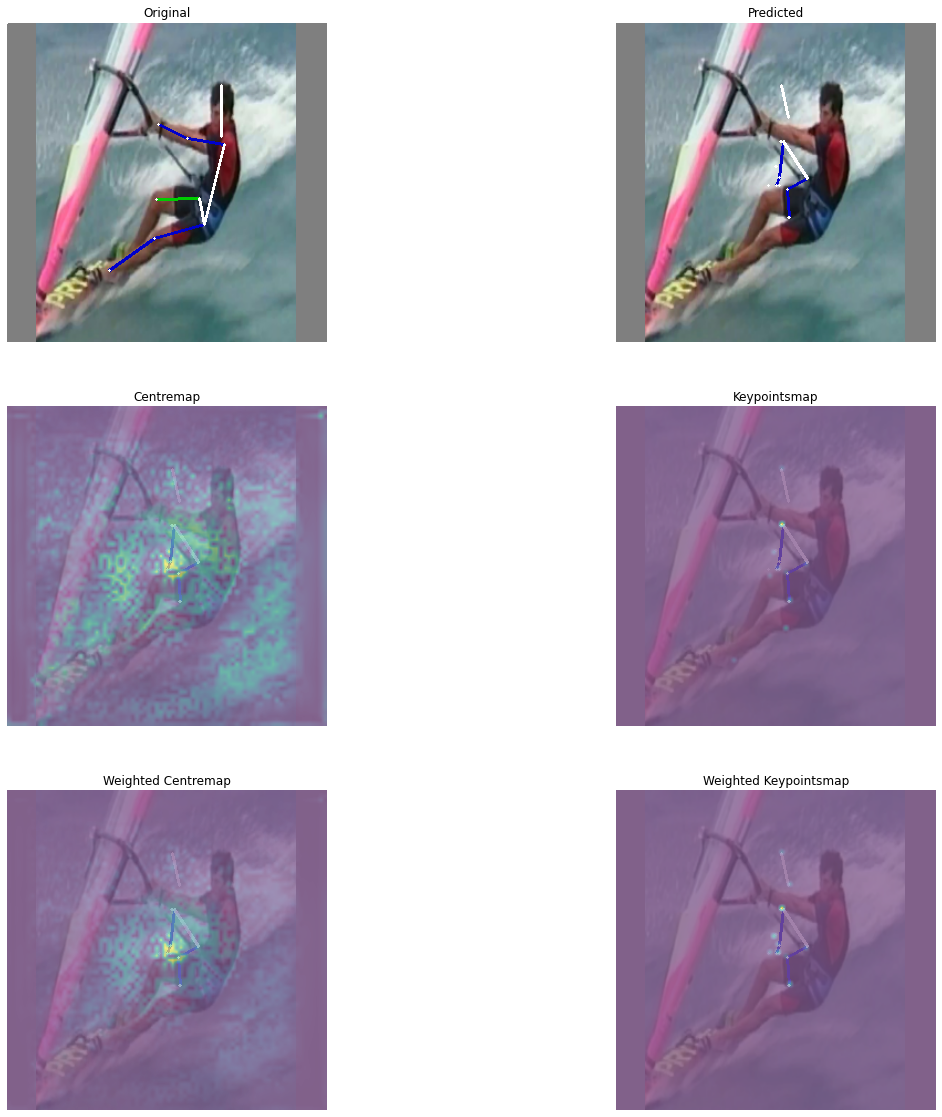

In [16]:
draw_sample(4)